In [80]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{max-width:80%!important;width:auto!important;}</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from tqdm.notebook import trange, tqdm

import cv2
import numpy as np

from pathlib import Path
colour = Path('../GTA_images/Simple/Colour')
depth = Path('../GTA_images/Simple/Depth')

import sys
sys.path.append('../')

from depth_Functions import (
    import_raw_colour_image, 
    import_raw_depth_image, 
    show_img,
    show_array_of_images
)

from Feature_Extraction import (
    get_patchsize,
    create_local_feature_vector,
    process_patches,
    image_from_patches
)

from Global_Depth import get_absolute_and_relative_depth

# [Equation](https://www.cs.cornell.edu/~asaxena/learningdepth/ijcv_monocular3dreconstruction.pdf)

Our goal is to create parameters for the function:

$$d_i = \theta_r x_i$$

To optimise the following equation:

$$P(d|X;\theta;\sigma_{1r}) = \frac{1}{Z}\exp{\left({-\sum_\limits{i=1}^{M}d_i-x_i^T\theta_r}\right)}$$

## Variables

| Variables |Description|
|-|-|
|$P(d|X)$|probable depth d given image features X|
|$\theta$|parameter calculated during training|
| Z | Normalisation constant |
| M | Number of patches |
|$d_i$|depth at a given patch|
|$x_i$|feature vector at patch|


# Training

## Equations

In training our goal is to determine $\theta$, this is done by maximising the value l(d):

 $$l(d) = \log{P(d|X;\theta_r)}$$


 $$l(d) = \log\left(\frac{1}{Z}\right)\left({-\sum_\limits{i=1}^{M}d_i-\theta_r x_i^T}\right)$$

Linear least squares is used to determine the value of $\theta$ that will maximise l(d), which occurs as:

$$\left({\sum_\limits{i=1}^{M}d_i-x_i^T\theta_r}\right) \rightarrow 0$$

$\therefore$ we can find the least square of the equation:

$$d_i = x_i^T\theta_r$$

In [181]:
from scipy import optimize

def function(x, *𝜃):
    print(x.shape)
    print(np.array(𝜃).shape)
    return x @ np.array(𝜃)

def least_squares(features, depth, 𝜃):
    return optimize.curve_fit(function, 
                              xdata=features.reshape(-1, features.shape[-1]), 
                              ydata=depth.flatten(),
                              p0=𝜃)

# Feature Example

## Images

In [4]:
sorted(colour.iterdir())

[PosixPath('../GTA_images/Simple/Colour/color_1.raw'),
 PosixPath('../GTA_images/Simple/Colour/color_2.raw'),
 PosixPath('../GTA_images/Simple/Colour/color_3.raw'),
 PosixPath('../GTA_images/Simple/Colour/color_4.raw'),
 PosixPath('../GTA_images/Simple/Colour/color_5.raw'),
 PosixPath('../GTA_images/Simple/Colour/color_6.raw')]

In [5]:
colour_images = [import_raw_colour_image(str(file)) for file in sorted(colour.iterdir())]
depth_images = [import_raw_depth_image(str(file)) for file in sorted(depth.iterdir())]

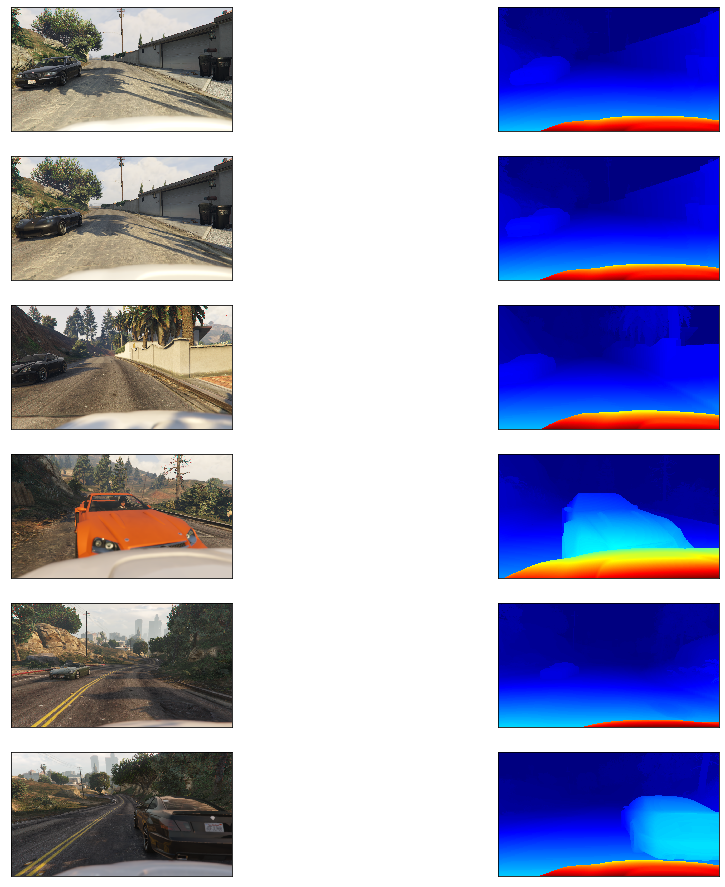

In [6]:
show_array_of_images([x for y in zip(colour_images, depth_images) for x in y], 
                     shape=(6,2), depthmap=True)

## Get the feature values of each patch

In [67]:
from tqdm.notebook import tqdm

features_120 = [process_patches(image, 120, function=create_local_feature_vector)
                for image in tqdm(colour_images, total=6, leave=False)]

In [68]:
features_120[0].shape

(120, 128, 34)

In [69]:
depths_120 = [process_patches(image, 120, function=np.mean)
                for image in tqdm(depth_images, total=6, leave=False)]

## Set an estimate for $\theta$: 
required as otherwise scipy will assume it is a scalar

In [70]:
𝜃 = [1e-5 for i in range(features_120[0].shape[-1])]

## Train accross each of first five images

In [71]:
for feature, depth in tqdm(zip(features_120[:-1], depths_120[:-1]),
                           total=len(features_120[:-1]), leave=False):
    𝜃,_ = least_squares(feature,  depth, 𝜃)

In [72]:
𝜃

array([ 1.13179541e-05,  1.50735226e-05,  8.68772682e-06, -2.83776977e-06,
       -1.52232070e-06,  1.40765637e-05,  2.52577583e-06, -2.63044862e-05,
       -2.53144912e-05, -4.24773107e-06,  5.85231159e-06, -1.71377953e-07,
       -1.36841593e-06,  1.53321355e-07,  4.91092355e-07,  3.95264756e-07,
       -9.84790480e-07, -7.85730194e-08, -1.00540010e-07, -6.28526475e-08,
       -2.25639055e-06, -1.10302774e-06, -1.04914998e-07, -3.19875246e-06,
        2.11915868e-07,  1.91502126e-07,  2.68297567e-08, -5.27507662e-08,
       -2.02836009e-06, -9.49913450e-07,  6.99564257e-07,  1.86038001e-06,
        2.58762449e-06,  2.98216260e-06])

In [73]:
import math

mean, std = np.mean(𝜃), np.std(𝜃)

𝜃_stand = [(weight-mean)/std for weight in 𝜃] 

In [74]:
import matplotlib.pyplot as plt

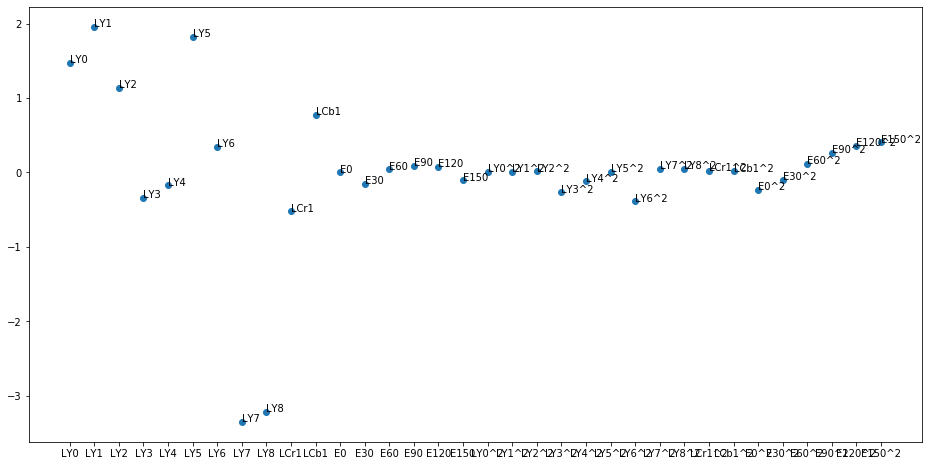

In [75]:
_, axis = plt.subplots(1,1,figsize=(16,8))

features = [f"LY{i}" for i in range(9)] + ["LCr1", "LCb1"] + [f"E{i}" for i in range(0,180,30)]

total = features + [f"{f}^2" for f in features]

axis.scatter(total, 𝜃_stand)

for x,y in enumerate(𝜃_stand):
    axis.annotate(total[x], xy=(x,y))

## Predict the depth for the final image

In [271]:
predicted_depth = features_120[-1] @ 𝜃

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 306 is different from 34)

In [77]:
predicted_depth.shape

(80, 80)

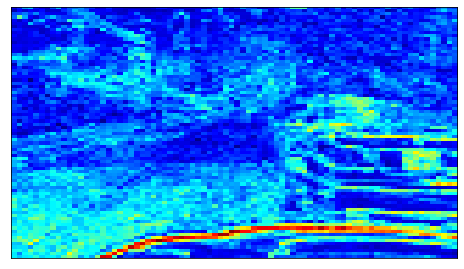

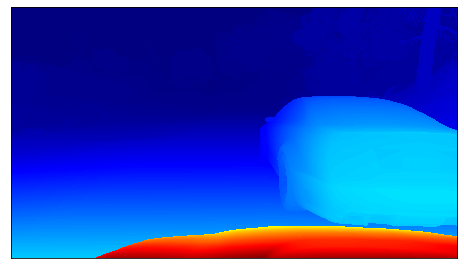

In [78]:
show_img(image_from_patches(predicted_depth, depth_images[0].shape), depthmap=True)
show_img(depth_images[-1], depthmap=True)

# Experiment at different patch sizes

/opt/conda/envs/bul7cv/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


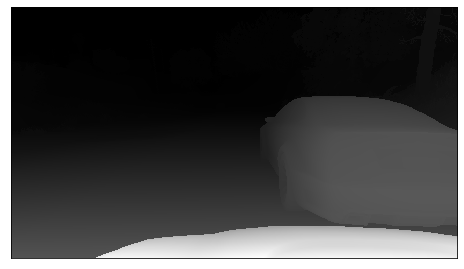

In [57]:
weights = []

show_img(depth_images[-1])

for nxm in trange(60, 301, 60):
    features_train = [process_patches(image, nxm, function=create_local_feature_vector)
                for image in tqdm(colour_images[:-1], total=5, leave=False, desc='feature extraction')]
    
    depth_train = [process_patches(image, nxm, function=np.mean) for image in depth_images[:-1]]
    
    weights.append([1e-5 for i in range(features_train[0].shape[-1])])
    
    for feature, depth in tqdm(zip(features_train, depth_train),
                           total=len(features_train), leave=False, desc='training'):
        weights[-1],_ = least_squares(feature,  depth, weights[-1])

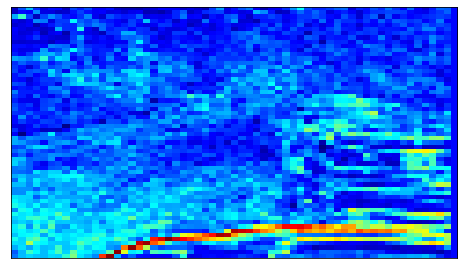

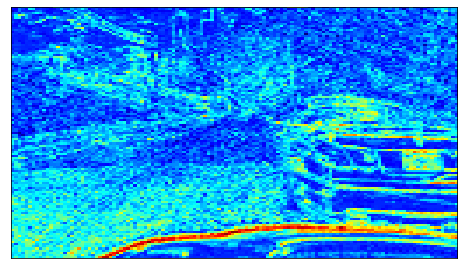

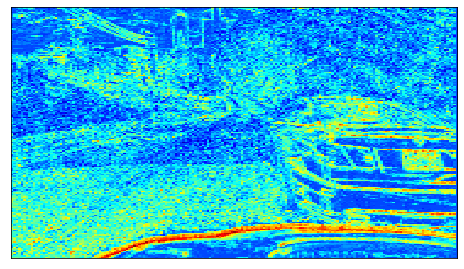

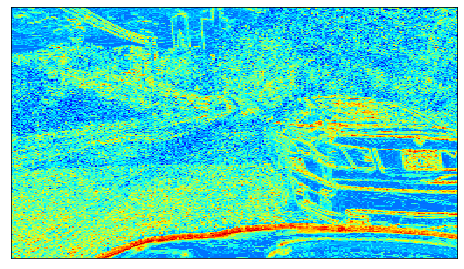

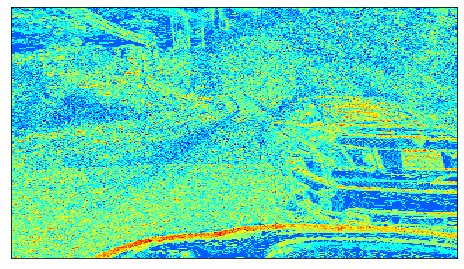

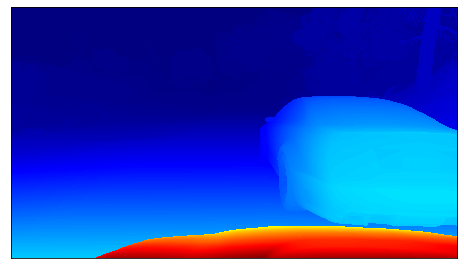

In [62]:
for i, weight in enumerate(weights):
    features_test = process_patches(colour_images[-1], 60*(i+1), function=create_local_feature_vector, name=f'{(i+1)*60}')
    predicted_depth = features_test @ weight
    show_img(image_from_patches(predicted_depth, depth_images[0].shape), depthmap=True)

show_img(depth_images[-1], depthmap=True)

# Experiment with a $\theta$ for each row

It can be considered that information within a row will be similar whilst information between rows will be different i.e. blue at the top most likely indicates sky, blue at the base mostly indicates sea

In [79]:
𝜃 = [[1e-5 for i in range(features_120[0].shape[-1])] for i in range(features_120[0].shape[0])]

In [83]:
len(𝜃)

120

In [84]:
features_120[0].shape

(120, 128, 34)

In [86]:
for feature, depth in tqdm(zip(features_120[:-1], depths_120[:-1]),
                           total=len(features_120[:-1]), leave=False):
    for i in trange(feature.shape[0], leave=False):
        𝜃[i],_ = least_squares(feature[i],  depth[i], 𝜃[i])

In [87]:
predicted_depth = np.zeros(features_120[-1].shape[:-1])

for row_number, feature_row  in enumerate(features_120[-1]):
    predicted_depth[row_number] = feature_row @  𝜃[row_number]

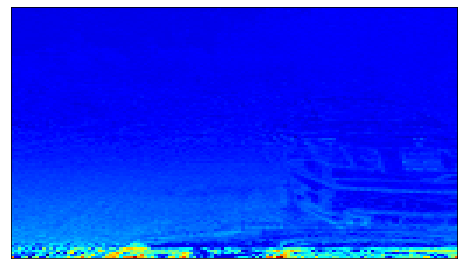

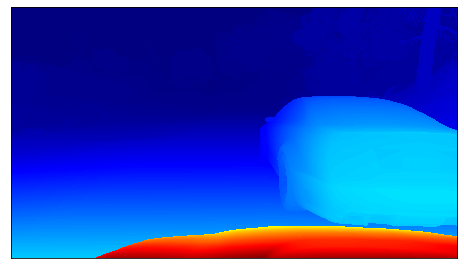

In [89]:
show_img( image_from_patches(predicted_depth, depth_images[-1].shape), depthmap=True)
show_img(depth_images[-1], depthmap=True)

# Using global features

In [31]:
global_6x8, relative_6x8 = [list(t) for t in zip(*[get_absolute_and_relative_depth(image,6,[(3,3),(9,9)])for image in tqdm(colour_images, leave=False, desc='images', total=len(colour_images))])]

In [94]:
global_6x8[0].shape

(120, 160, 646)

In [51]:
depths_6x8 = [process_patches(image, get_patchsize(image.shape, 6), function=np.mean)
              for image in tqdm(depth_images, total=6, leave=False)]

In [53]:
depths_6x8[0].shape

(120, 160)

In [47]:
𝜃 = [1e-5 for i in range(global_6x8[0].shape[-1])]
len(𝜃)

646

In [57]:
for feature, depth in tqdm(zip(global_6x8[:-1], depths_6x8[:-1]),
                           total=len(global_6x8[:-1]), leave=False):
    𝜃,_ = least_squares(feature,  depth, 𝜃)

In [76]:
import math

mean, std = np.mean(𝜃), np.std(𝜃)

𝜃_stand = [(weight-mean)/std for weight in 𝜃] 

In [123]:
features = [f"LY{i}" for i in range(9)] + ["LCr1", "LCb1"] + [f"E{angle}" for angle in range(0,180,30)]
features += [f"{f}^2" for f in features]
directions = ['Ce', 'Up', 'Do', 'Le', 'Ri']
adjacent= [f'{direction}{feature}' for (direction, feature) in itertools.product(directions,features)]
total = adjacent+['fCo{i}' for i,feature in itertools.product(range(4), features)]
total += [f'S{i}{feature}' for i,feature in itertools.product([3,9], adjacent)]

In [121]:
len(𝜃)
len(𝜃_stand)
len(total)

646

646

646

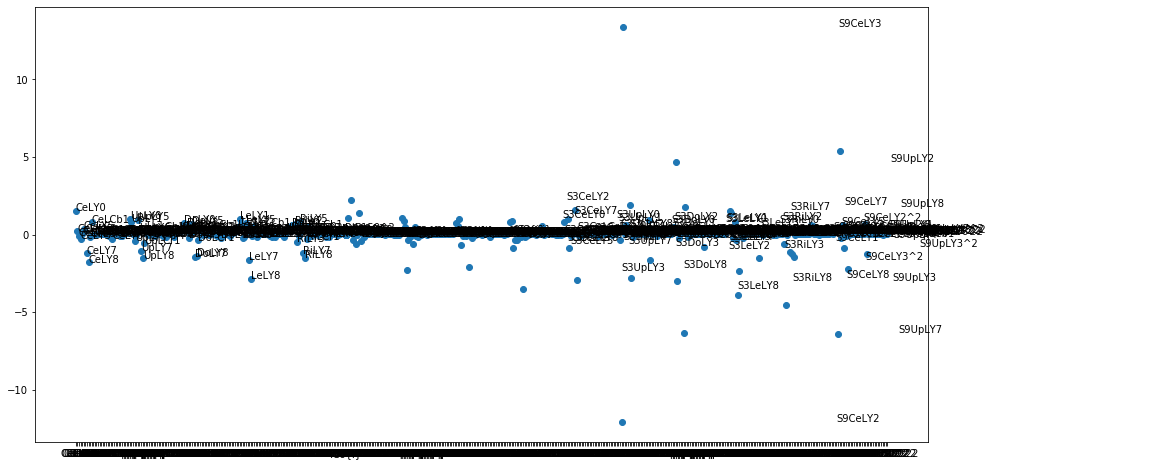

In [124]:
import itertools
import matplotlib.pyplot as plt
_, axis = plt.subplots(1,1,figsize=(16,8));

_ = axis.scatter(total, 𝜃_stand);

for x,y in enumerate(𝜃_stand):
    axis.annotate(total[x], xy=(x,y));

pass;

In [60]:
predicted_depth = global_6x8[-1] @ 𝜃

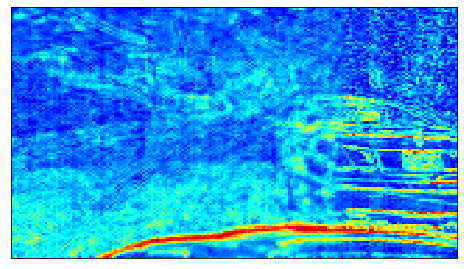

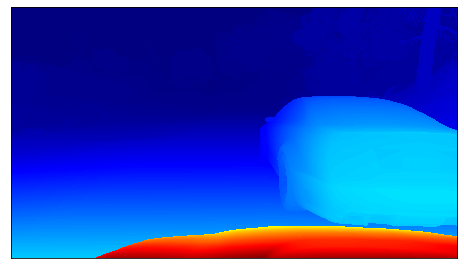

In [64]:
show_img(image_from_patches(predicted_depth, get_patchsize(depth_images[-1].shape,6)), depthmap=True)
show_img(depth_images[-1], depthmap=True)

## Global $\theta$ per row

In [126]:
𝜃 = [[1e-5 for i in range(global_6x8[0].shape[-1])] for i in range(global_6x8[0].shape[0])]

In [130]:
len(𝜃)
len(𝜃[0])
global_6x8[0].shape

120

646

(120, 160, 646)

In [201]:
def function(x, *𝜃):
    return x @ np.array(𝜃)

def least_squares(features, depth, 𝜃):

    return optimize.curve_fit(function, 
                              xdata=features.reshape(-1, features.shape[-1]), 
                              ydata=depth.flatten(),
                              p0=𝜃)

In [202]:
for feature, depth in tqdm(zip(global_6x8[:-1], depths_6x8[:-1]),
                           total=len(global_6x8[:-1]), leave=False):
    for i in trange(feature.shape[0], leave=False):
        𝜃[i],_ = least_squares(feature[i],  depth[i], 𝜃[i])

0


TypeError: Improper input: N=646 must not exceed M=160

In [169]:
(global_6x8[0][0] @ np.array(𝜃[0])).shape

(160,)

In [178]:
depths_6x8[0][0]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.80599434e-04, 1.97805290e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.66458034e-04, 4.14816517e-04, 4.41347831e-04,
       7.98652618e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      